In [1]:
import fsspec
import numpy as np
import pystac
import stac2dcache
import xarray as xr

In [2]:
# Define parameters for leaf-spring-index calculation
year = 1980
startdate = 1  # First date for calculating growing degree hours (GDH)
enddate = 200  # Last date for calculating GDH
bbox = (-124.784, 24.743, -66.951, 49.346)  # bbox expressed in lat/long degree

In [3]:
catalog_urlpath = (
    "dcache://pnfs/grid.sara.nl/data/remotesensing/disk/"
    "daymet-daily-v4/catalog.json"
)

In [4]:
BASE_TEMP_FAHRENHEIT = 32.
LEAF_INDEX_COEFFS = xr.DataArray(
    data=np.array([
        [3.306, 13.878, 0.201, 0.153],
        [4.266, 20.899, 0.000, 0.248],
        [2.802, 21.433, 0.266, 0.000],
    ]),
    dims=("plant", "variable"),
    coords={"plant": ["lilac", "arnold red", "zabelli"]}
)
BLOOM_INDEX_COEFFS = xr.DataArray(
    data=np.array([
        [-23.934, 0.116],
        [-24.825, 0.127],
        [-11.368, 0.096],
    ]),
    dims=("plant", "variable"),
    coords={"plant": ["lilac", "arnold red", "zabelli"]}
)
LEAF_INDEX_LIMIT = 637


def read_remote_dataset(urlpath, chunks=None):
    of = fsspec.open(urlpath, block_size=4*2**20)
    ds = xr.open_dataset(of.open(), engine="h5netcdf", chunks=chunks) 
    return ds


def calculate_gdh(dayl, tmin, tmax):
    """ 
    Function to calculation growing degree hours. 
    """
    
    ideal_dl = np.floor(dayl)

    # Calculate sunset temperature
    dt = tmax - tmin
    sunset = dt*np.sin(np.pi/(dayl + 4)*dayl) + tmin
    
    hours = xr.DataArray(np.arange(24), dims=("hours",))
    
    a = hours - ideal_dl
    log1 = np.log(a, where=a>0)
    eq1 = dt*np.sin(hours * np.pi/(dayl + 4)) + tmin
    eq2 = sunset - (sunset - tmin)/(np.log(24 - dayl))*log1
    t = xr.where(a<=0, eq1, eq2) - BASE_TEMP_FAHRENHEIT
    t = t.clip(min=0)
    return t.sum(dim="hours")


def pred(gdh, day):
    """
    Function to calculation predictors for calculating first leaf and first bloom dates.
    """
    
    # Calculating dde2 - trailing 3 days GDH sum from day i to day i-2
    dde2 = gdh.rolling(time=3, center=False).sum()
    dde2[0,:,:] = gdh[0,:,:]*3
    dde2[1,:,:] = gdh[1,:,:] + gdh[0,:,:]*2

    # Calculating aggregate GDH 
    agdh = gdh.cumsum(axis=0)

    # Calculating dd57 - trailing 5-7 days GDH sum from day i-5 to i-7
    dd57 = gdh.rolling(time=8, center=False, min_periods=1).sum() - gdh.rolling(time=5, center=False, min_periods=1).sum()

    # Calculating MDS0
    mds0 = day - 1
    mds0, _ = xr.broadcast(mds0, gdh)

    return dde2, agdh, dd57, mds0


def calculate_first_bloom(mds0, agdh):
    """
    Function to calculate day of first bloom for each plant species from GDH.
    """
    outdate = xr.zeros_like(tmin)

    #Prediction calculation for first bloom
    mdsum = BLOOM_INDEX_COEFFS[:,0]*mds0 \
        + BLOOM_INDEX_COEFFS[:,1]*agdh
    
    mdbool = mdsum>999.5  # Calculate all occurences of first bloom

    # Vectorized approach to identifying first day of bloom
    outdate = mdbool.argmax(dim="time")
    return outdate


def calculate_first_leaf(mds0, dde2, dd57):
    """
    Function to calculate day of first leaf for each plant species from GDH.
    """ 
    
    # Calculating synop
    synflag = dde2>=LEAF_INDEX_LIMIT
    synop = synflag.cumsum(dim="time")
            
    # Prediction calculation for first leaf
    mdsum = LEAF_INDEX_COEFFS[:,0]*mds0 \
        + LEAF_INDEX_COEFFS[:,1]*synop \
        + LEAF_INDEX_COEFFS[:,2]*dde2 \
        + LEAF_INDEX_COEFFS[:,3]*dd57

    mdbool = mdsum>999.5  # Calculate all occurences of first leaf

    # Vectorized approach to identifying first day of leaf
    outdate = mdbool.argmax(dim="time")
            
    # Arnold red's first leaf date is one day after reaching mdsum limit
    outdate.loc["arnold red",:,:] += 1 

    return outdate

In [5]:
catalog = pystac.Catalog.from_file(catalog_urlpath)

In [6]:
item = catalog.get_item(f"na-{year}", recursive=True)
item

<Item id=na-1980>

In [7]:
tmin_href = item.assets["tmin"].get_absolute_href()
tmax_href = item.assets["tmax"].get_absolute_href()
dayl_href = item.assets["dayl"].get_absolute_href()

In [12]:
ds = read_remote_dataset(dayl_href)
mask = (ds.lon > bbox[0]) \
    & (ds.lat > bbox[1]) \
    & (ds.lon < bbox[2]) \
    & (ds.lat < bbox[3])
mask = mask.where(mask, drop=True)

In [13]:
ds = read_remote_dataset(
    dayl_href, 
    chunks={"time": 1, "x": 1000, "y": 1000}
)
ds = ds.isel(time=slice(startdate-1, enddate))
ds = ds.sel(
    x=slice(mask.x[0], mask.x[-1]), 
    y=slice(mask.y[0], mask.y[-1])
)
dayl = ds["dayl"]
day = ds["yearday"]

In [14]:
ds = read_remote_dataset(
    tmin_href, 
    chunks={"time": 1, "x": 1000, "y": 1000}
)
ds = ds.isel(time=slice(startdate-1, enddate))
ds = ds.sel(
    x=slice(mask.x[0], mask.x[-1]), 
    y=slice(mask.y[0], mask.y[-1])
)
tmin = ds["tmin"]

In [15]:
ds = read_remote_dataset(
    tmax_href, 
    chunks={"time": 1, "x": 1000, "y": 1000}
)
ds = ds.isel(time=slice(startdate-1, enddate))
ds = ds.sel(
    x=slice(mask.x[0], mask.x[-1]), 
    y=slice(mask.y[0], mask.y[-1])
)
tmax = ds["tmax"]

In [16]:
# convert temperatures to Fahrenheit
tmax = tmax * 1.8 + 32
tmin = tmin * 1.8 + 32
# convert daylength from seconds to hours
dayl = dayl / 3600

In [17]:
tmin

<xarray.DataArray 'tmin' (time: 200, y: 3088, x: 5727)>
dask.array<add, shape=(200, 3088, 5727), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 -2.473e+06 -2.472e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 1.176e+06 1.175e+06 1.174e+06 ... -1.91e+06 -1.911e+06
    lat      (y, x) float32 dask.array<chunksize=(192, 913), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(192, 913), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-07-18T12:00:00

In [18]:
from dask.distributed import Client

client = Client("tcp://10.0.2.38:41615")
client

<Client: 'tcp://10.0.2.38:41615' processes=15 threads=60, memory=450.00 GiB>

In [19]:
client.wait_for_workers(n_workers=15)

In [20]:
tmin, tmax, dayl, day = client.persist([tmin, tmax, dayl, day])

In [21]:
# ***********PART 2--- Mapping the gdh function to the collection************/
gdh = xr.map_blocks(
    calculate_gdh,
    dayl,
    args=(tmin, tmax),
    template=dayl
)
# ****************************END OF PART 2**********************************/

In [22]:
# *******************PART 3--- CALCULATING PREDICTORS************************/
dde2, agdh, dd57, mds0 = pred(gdh, day)
# ****************************END OF PART 3**********************************/

In [23]:
# ****************PART 4--- CALCULATING LEAF/BLOOM DATES*********************/
first_leaf = calculate_first_leaf(mds0, dde2, dd57)
# first_bloom = calculate_first_bloom(mds0, agdh)
# ****************************END OF PART 4**********************************/

In [24]:
first_leaf

<xarray.DataArray (plant: 3, y: 3088, x: 5727)>
dask.array<setitem, shape=(3, 3088, 5727), dtype=int64, chunksize=(3, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * plant    (plant) <U10 'lilac' 'arnold red' 'zabelli'
  * y        (y) float64 1.176e+06 1.175e+06 1.174e+06 ... -1.91e+06 -1.911e+06
  * x        (x) float64 -2.473e+06 -2.472e+06 ... 3.252e+06 3.253e+06
    lat      (y, x) float32 dask.array<chunksize=(192, 913), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(192, 913), meta=np.ndarray>

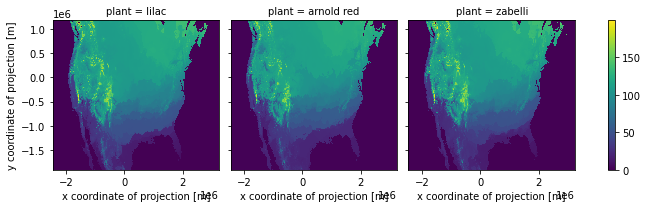

In [25]:
first_leaf.plot(col="plant")

In [ ]:
client.close()